# Generating new faces with Variational Autoencoders
Dhanush Kamath | [GitHub](https://github.com/dhanushkamath) | [LinkedIn](https://www.linkedin.com/in/dhanushkamath/)

Deep generative models such as Generative Adversarial Networks (GANs) are gaining tremendous popularity, both in the industry as well as academic research. In fact, Yann LeCun, the father of the Convolutional Neural Network, described it as “the most interesting idea in the last 10 years in Machine Learning.” The idea of a computer program generating new human faces or new animals can be quite exciting. Deep generative models take a slightly different approach compared to supervised learning which we shall discuss very soon.

This quick and concise tutorial covers the basics of Deep Generative Modelling with Variational Autoencoders. I am assuming that you are fairly familiar with the concepts of Convolutional Neural Networks and representation learning. If not, I would recommend watching Andrej Karpathy's [CS231n lecture videos](https://www.youtube.com/playlist?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC) as they are, in my honest opinion, the best resource for learning CNNs on the internet. You can also find the lecture notes for the course [here](http://cs231n.github.io/).

This example demonstrates the process of building and training a VAE using Keras to generate new faces. We shall be using the [CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/jessicali9530/celeba-dataset) from Kaggle and [Google Colab](https://colab.research.google.com/) for training the VAE model.

## GENERATIVE MODELS

If you're beginning to explore the field of Generative Deep Learning, a Variational Autoencoder (VAE) is ideal to kick off your journey. The VAE architecture is intuitive and simple to understand. Contrary to a discriminative model such as a CNN classifier a generative model attempts to learn the underlying distribution of the data rather than classifying the data into one of many categories. A well trained CNN classifier would be highly accurate in differentiating an image of a car from that of a house. However, this does not accomplish our objective of generating images of cars and houses.

A discriminative model learns to capture useful information from the data and utilise that information to classify a new data point into one of two or more categories. From a probabilistic perspective, a discriminative model estimates the probability $p(y|x)$, where $y$ is the category or class and $x$ is the data point. It estimates the probability of a datapoint $x$ belonging to the category $y$. For example, the probability of an image being that of a car or a house. 

A generative model learns the underlying distribution of the data that explains how the data was generated. In essence, it mimics the underlying distribution and allows us to sample from it to generate new data. It can be defined as estimating the probability $p(x)$, where $x$ is the data point. It estimates the probability of observing the data point $x$ in the distribution. 



## SIMPLE AUTOENCODER

Before delving into a Variational Autoencoder, it is crucial to analyse a simple Autoencoder. 

A simple or Vanilla Autoencoder consists of two neural networks - an Encoder and a Decoder. An Encoder is responsible for converting an image into a compact lower dimensional vector (or latent vector). This latent vector is a compressed representation of the image. The Encoder, therefore maps an input from the higher dimensional input space to the lower dimensional latent space. This is similar to a CNN classifier. In a CNN classifier, this latent vector would be subsequently fed into a softmax layer to compute individual class probabilities. However in an Autoencoder, these outputs are fed into the Decoder. The Decoder is a different neural network that tries to reconstruct the image, thereby mapping from the lower dimenstional latent space to the higher dimensional output space. The Encoder and Decoder perform mappings that are exactly opposite to each other, as shown in the image <i>img-1</i>. 


<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png"> 
<br><i>img-1</i>
<br><i>Source : en.wikipedia.org/wiki/Autoencoder</i>

<br><br>
Consider the following analogy to understand this better. Imagine you're playing a game with your friend over the phone. The rules of the game are simple. You are presented with a number of different cylinders. Your task is to describe the cylinders to your friend who will then attempt to recreate them out of modelling clay. You are forbidden from sending pictures. How will you convey this information? 

Since any cylinder can be constructed with two parameters - its height and diameter, the most efficient strategy would be to estimate these two measures and convey them to your friend. Your friend, upon receiving this information can then reconstruct the cylinder. In this example, it is quite evident that you are performing the function of an Encoder by condensing visual information into two quantities. Your friend on the contrary, is performing the function of a Decoder by utilising this condensed information to recreate the cylinder.




## HOUSEKEEPING

### Downloading the dataset
The dataset can be downloaded directly into your Google Colab environment using the [Kaggle API](https://www.kaggle.com/docs/api) as shown below. You can refer to this [post](https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235) on Medium for more details.

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

\Upload Kaggle.json downloaded from your registered kaggle account

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marcpartensky1","key":"9436b7bf536531e3d727cdcdd4bff3bc"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [01:05<00:00, 24.7MB/s]
100% 1.33G/1.33G [01:05<00:00, 21.8MB/s]


In [ ]:
import os
from glob import glob

WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/img_align_celeba/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

Caution (for Colab users) : Do not attempt to explore the directory using the viewer on the left as the page becomes unresponsive owing to the large size of the dataset.

### Imports

In [ ]:
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

###Data

In [ ]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


Since the dataset is quite large, we shall create an <i>ImageDataGenerator</i> object and employ its member function - <i>flow_from_directory</i> to define the flow of data directly from disk rather than loading the entire dataset into memory. The ImageDataGenerator can also be used to dynamically apply various transformations for image augmentation which is particularly useful in the case of small datasets.

I highly encourage you to refer to the [documentation](https://keras.io/preprocessing/image/#flow_from_directory) for understanding the various parameters of the dataflow function. 

In [ ]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)

train_datagen = ImageDataGenerator(rescale=1./255)
data_flow = train_datagen.flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training',
                                                                   )

Found 202599 images belonging to 1 classes.


### MODEL ARCHITECTURE


####Building the Encoder

In [ ]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)

      x = LeakyReLU()(x)
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

<br><br>
The architecture of the Encoder, as shown below, consists of a stack of convolutional layers followed by a dense (fully connected) layer which outputs a vector of size 200.


<i>Note : The combination of padding = 'same' and stride = 2 will produce an output tensor half the size of the input tensor in both height and width. The depth/channels aren't affected as they are numerically equal to the number of filters. </i>
<br><br>

In [ ]:
encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0     

####Building the Decoder


In [ ]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

<br><br>
Recall that it is the function of the Decoder to reconstruct the image from the latent vector. Therefore, it is necessary to define the decoder so as to increase the size of the activations gradually through the network. This can be achieved either through the [UpSampling2D](https://keras.io/layers/convolutional/#upsampling2d) layer or the [Conv2DTransponse](https://keras.io/layers/convolutional/#conv2dtranspose) layer.

Here, the Conv2DTranspose Layer is employed. This layer produces an output tensor double the size of the input tensor in both height and width.

<i>Note : The Decoder, in this example, is defined to be a mirror image of the encoder, which is not mandatory.</i>

<br><br>

In [ ]:
decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],                                        
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 4096)              823296    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 16, 16, 64)       36928     
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 32, 32, 64)       36928     
 pose)                                                     

#### Attaching the Decoder to the Encoder

In [ ]:
# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

simple_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0   

### COMPILATION AND TRAINING

The loss function used is a simple Root Mean Square Error (RMSE). The true output is the same batch of images that was fed to the model at its input layer. The Adam optimizer is optimizing the RMSE error for encoding the batch of images into their respective latent vectors and subsequently decoding them to reconstruct the images. 

The ModelCheckpoint Keras callback saves the model weights for reuse. It overwrites the file with a fresh set of weights after every epoch.

NOTE : If you're using Google Colab, either download the weights to disc or mount your Google Drive.

In [ ]:
LEARNING_RATE = 0.0005
N_EPOCHS = 10

optimizer = Adam(lr = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

simple_autoencoder.compile(optimizer=optimizer, loss = r_loss)

checkpoint_ae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/weights.h5'), save_weights_only = True, verbose=1)


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


<i>TIP</i> : Here's a really useful tip I found on Reddit (by arvind1096) - to prevent Google Colab from disconnecting due to a timeout issue, execute the following JS function in the Google Chrome console. 

<br>
function ClickConnect(){console.log("Working");document.querySelector("colab-toolbar-button#connect").click()}setInterval(ClickConnect,60000)

In [14]:
simple_autoencoder.fit_generator(data_flow, 
                                 shuffle=True, 
                                 epochs = N_EPOCHS, 
                                 initial_epoch = 0, 
                                 steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                                 callbacks=[checkpoint_ae])

<ipython-input-14-f80bf638e636>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  simple_autoencoder.fit_generator(data_flow,


Epoch 1/10
396/395 [==============================] - ETA: 0s - loss: 0.0291
Epoch 1: saving model to ./weights/AE/weights.h5
395/395 [==============================] - 400s 985ms/step - loss: 0.0291
Epoch 2/10
396/395 [==============================] - ETA: 0s - loss: 0.0108
Epoch 2: saving model to ./weights/AE/weights.h5
395/395 [==============================] - 388s 980ms/step - loss: 0.0108
Epoch 3/10
396/395 [==============================] - ETA: 0s - loss: 0.0091
Epoch 3: saving model to ./weights/AE/weights.h5
395/395 [==============================] - 380s 960ms/step - loss: 0.0091
Epoch 4/10
396/395 [==============================] - ETA: 0s - loss: 0.0084
Epoch 4: saving model to ./weights/AE/weights.h5
395/395 [==============================] - 384s 971ms/step - loss: 0.0084
Epoch 5/10
396/395 [==============================] - ETA: 0s - loss: 0.0080
Epoch 5: saving model to ./weights/AE/weights.h5
395/395 [==============================] - 378s 955ms/step - loss: 0.0080


### RECONSTRUCTION

The first step is to generate a new batch of images using the ImageDataGenerator defined in the 'Data' section at the top. The images are returned as an array and the number of images is equal to BATCH_SIZE. 

In [15]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [16]:
example_images.shape

(10, 128, 128, 3)

#### Displaying the reconstructed images

In [17]:
import matplotlib.pyplot as plt

In [18]:
def plot_compare(images=None, add_noise=False):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]

  if add_noise:
    encodings = encoder.predict(images)
    encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
    reconst_images = decoder.predict(encodings)

  else:
    reconst_images = simple_autoencoder.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

1/1 [==============================] - 0s 363ms/step


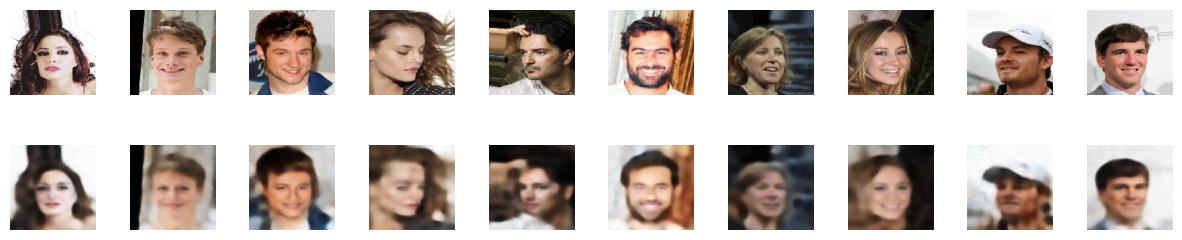

In [19]:
plot_compare(example_images)

The first row shows images directly from the dataset and the second row shows images that have been passed through the Autoencoder. Evidently, the model has learned to encode and decode (reconstruct) fairly well. 

NOTE : A reason why the images lack sharpness is due to the RMSE loss as it averages out the differences between individual pixel values. Generative Adversarial Networks on the contrary, produce much sharper images.

### DRAWBACKS

#### Adding noise vectors sampled from a standard normal distribution to the image encodings

1/1 [==============================] - 0s 128ms/step


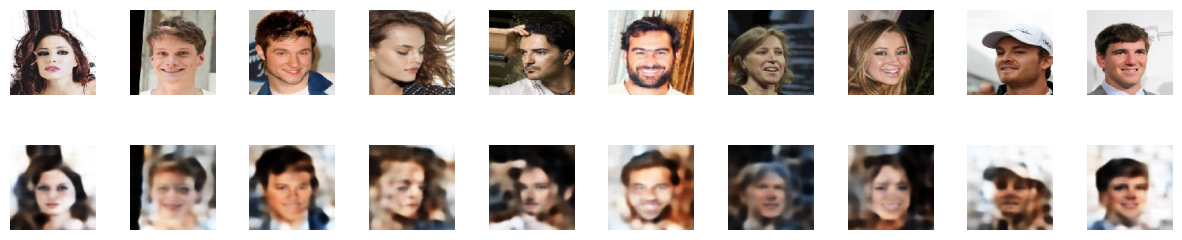

In [20]:
plot_compare(images = example_images, add_noise = True)

It can be observed that the images are starting to get distorted with a bit of noise added to its encodings. One possible reason could be that the model did not ensure that the space around the encoded values (latent space) was continuous.

### Attempting to generate images from latent vectors sampled from a standard normal distribution

In [21]:
def generate_images_from_noise(n_to_show = 10): 
  reconst_images = decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

1/1 [==============================] - 0s 35ms/step


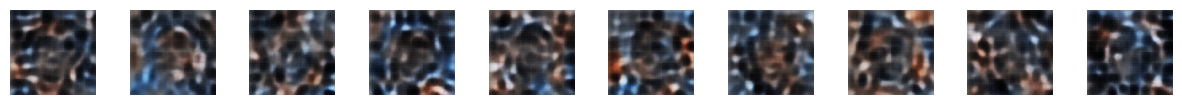

In [22]:
generate_images_from_noise()

It is evident that the latent vector sampled from a standard normal distribution can not be used to generate new faces. This shows that the latent vectors generated by the model are not centered/symmetrical around the origin. This also strengthens our inference that the latent space is not continuous.

Since we do not have a definite distribution to sample latent vectors from, it is unclear as to how we can generate new faces. We observed that adding a bit of noise to the latent vector does not produce new faces. We can encode and decode images but that does not meet our objective. 

Building on this thought, wouldn't it be great if we could generate new faces from latent vectors sampled from a standard normal distribution? This is essentially what a Variational Autoencoder does.

## VARIATIONAL AUTOENCODER



Variational Autencoders tackle most of the problems discussed above. They are trained to generate new faces from latent vectors sampled from a standard normal distribution. While a Simple Autoencoder learns to map each image to a fixed point in the latent space, the Encoder of a Variational Autoencoder (VAE) maps each image to a z-dimensional standard normal distribution. 



#### How can a simple Autoencoder be modified to make the encoder map to a z-dimensional standard normal distribution?

Any z-dimensional normal distribution can be represented by a mean vector $\mu$ and a covariance matrix $\Sigma$.

<br>
<center>
$\mu= \begin{pmatrix} \mu_1\\ \vdots \\\mu_z \end{pmatrix},
\ \ \ \Sigma =
\begin{pmatrix} \sigma_1^2 & \rho\sigma_1\sigma_2 & \cdots &   \rho\sigma_1\sigma_z   
\\ \rho\sigma_2\sigma_1 & \sigma_z^2 & \cdots & \rho\sigma_2\sigma_z
\\ \vdots & \vdots & \ddots & \vdots 
\\ \rho\sigma_z\sigma_1 & \rho\sigma_z\sigma_2 & \cdots & \sigma_z^2 \end{pmatrix}
$
</center>
<br><br>

<b>Therefore, in the case of a VAE, the encoder should output  a mean vector ($\mu$) and a covariance matrix ($\Sigma$) to map to a normal distribution, right?</b>

Yes, however, there are slight modifications to be made to the covariance matrix $\Sigma$.

<b>Modification 1) </b>It is assumed that there is no correlation between the elements of the latent vector. Hence, the non diagonal elements, representing covariance, are all zeroes. The covariance matrix is therefore, a diagonal matrix.

<br>
<center>
$\Sigma =\begin{pmatrix} \sigma_1^2 & 0 & \cdots & 0  
\\ 0 & \sigma_z^2 & \cdots & 0
\\ \vdots & \vdots & \ddots & \vdots 
\\ 0 & 0 & \cdots & \sigma_z^2 \end{pmatrix}$
</center>
<br>

As the diagonal elements of this matrix represent variance, it is simply represented as $\sigma^2$, a z-dimensional variance vector.

<br>
<center>
$\sigma^2 =\begin{pmatrix} \sigma_1^2 
\\ \vdots  
\\ \sigma_z^2 \end{pmatrix}$
</center>
<br>

<b>Modification 2) </b> Recall that the variance can only take non-negative values. To ensure that the output of the encoder is unbounded, the encoder is actually mapped to the mean vector and the <b>logarithm</b> of the variance vector. The logarithm ensures that the output can now take up any value in the range, $(-\infty,\infty)$. This makes training easier as the outputs of the neural network are naturally unbounded.

<b>Now, how is it ensured that the Encoder maps to a standard normal distribution (i.e., with a mean of 0 and a standard deviation of 1)?</b>

Enter KL divergence.

<b>KL divergence</b> provides a measurement of the extent to which one probability distribution differs from another. The KL divergence between a distribution with mean $\mu$ and standard deviation $\sigma\$, and the standard normal distribution, takes up the form:

<br>
<center>
$D_{KL}[N(\mu,\sigma) \ || \ N(0,1)] = \frac{1}{2}\sum_{i=1}^{z}(1+\log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$
</center>
</br>


By slightly modifying the loss function to include the KL divergence loss in addition to the RMSE loss, the VAE is forced to ensure that the encodings are very similar to a multivariate standard normal distribution. Since a multivariate standard normal distribution has a zero mean, it is centered around the origin. Mapping each image to a standard normal distribution as opposed to a fixed point ensures that the latent space is continuous and the latent vectors are centered around the origin.

Take a look at the image <i>img-2</i> for a better understanding.

<br>
<img src="https://blog.bayeslabs.co/assets/img/vae.jpg"> 
<br><i>img-2</i>
<br><i>Source : blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae</i>



#### If the encoder maps to $\mu$ and $\sigma$ instead of a z-dimensional latent vector, what is the input given to the Decoder during training?

The input to the Decoder, as shown in <i>img-2</i>, is a vector sampled from the normal distribution represented by the output of the Encoder - $\mu$ and $\sigma$. This sampling can be done as follows:

<center>
$Z = \mu + \sigma\varepsilon$
</center>

where $\varepsilon$ is a sampled from a multivariate standard normal distribution.



#### How do we generate new faces?

Since the KL divergence ensures that the encoder maps as close to a standard normal distribution as possible, we can sample from a z-dimensional standard normal distribution and feed it to the decoder to generate new images.

#### Does the decoder require any modification?
No, the decoder remains the same. It is identical to that of a Simple Autoencoder.

### CODE

#### Building the Encoder


In [23]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BatchNormalization()(x)
  
      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(rate=0.25)(x)

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)
  
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [24]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

vae_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 64)   18496       ['leaky_re_lu[0][0]']        

#### Building the Decoder
Since the Decoder remains the same, the Decoder architecture of the Simple Autoencoder is reused.

In [25]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 4096)              823296    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 16, 16, 64)       36928     
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 32, 32, 64)       36928     
 pose)                                                     

#### Attaching the Decoder to the Encoder


In [26]:
# The input to the model will be the image fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 64)   18496       ['leaky_re_lu[0][0]']      

### COMPILATION AND TRAINING


The loss function is a sum of RMSE and KL Divergence. A weight is assigned to the RMSE loss, known as the loss factor. The loss factor is multiplied with the RMSE loss. If we use a high loss factor, the drawbacks of a Simple Autoencoder start to appear. However, if we use a loss factor too low, the quality of the reconstructed images will be poor. Hence the loss factor is a hyperparameter that needs to be tuned.

In [27]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

In [28]:
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

In [29]:
adam_optimizer = Adam(lr = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)

In [30]:
vae_model.fit_generator(data_flow, 
                        shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                        callbacks=[checkpoint_vae])

<ipython-input-30-5c7d334b648d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vae_model.fit_generator(data_flow,


Epoch 1/200


TypeError: ignored

### RECONSTRUCTION.
The reconstruction process is the same as that of the Simple Autoencoder.

In [ ]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [ ]:
def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

In [ ]:
plot_compare_vae(images = example_images)

### Generating new faces from random vectors sampled from a standard normal distribution. 

In [ ]:
def vae_generate_images(n_to_show=10):
  reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

In [ ]:
vae_generate_images(n_to_show=10)

The VAE is evidently capable enough of producing new faces from vectors samped from a standard normal distribution. The fact that a neural network is capable of generating new faces from random noise shows how powerful it is in performing extremely complex mappings!

As it is impossible to visualize a 200 dimensional vector, some of the elements of the latent vector are individually visualized to see if they are close to a standard normal distribution.

In [ ]:
from scipy.stats import norm

In [ ]:
z_test = vae_encoder.predict(example_batch[:200])

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

It is observed that the first 50 elements of the Z dimensional vector are very similar to a standard normal distribution. The addition of the KL divergence term is therefore, justified. 